In [1]:
import torch
import torch.nn as nn

from einops import rearrange
from functools import partial
from omegaconf import OmegaConf
from pathlib import Path

from lola.autoencoder import get_autoencoder
from lola.data import field_postprocess, field_preprocess, get_well_inputs, get_well_multi_dataset
from lola.emulation import decode_traj, emulate_rollout, emulate_surrogate, encode_traj
from lola.plot import draw_movie, plot_psd
from lola.surrogate import get_surrogate

_ = torch.manual_seed(0)

In [2]:
# runpath = Path("/mnt/ceph/users/frozet/lola/runs/sm/ses7lyf5_rayleigh_benard_pixel_vit_pixel/")  # fmt: off
# runpath = Path("/mnt/ceph/users/frozet/lola/runs/sm/chua0k42_rayleigh_benard_f32c4_vit_large/")  # fmt: off
# runpath = Path("/mnt/ceph/users/frozet/lola/runs/sm/xp1prkdo_rayleigh_benard_f32c16_vit_large/")  # fmt: off
# runpath = Path("/mnt/ceph/users/frozet/lola/runs/sm/fa6jeugp_rayleigh_benard_f32c32_vit_large/")  # fmt: off
runpath = Path("/mnt/ceph/users/frozet/lola/runs/sm/lrg1qgi2_rayleigh_benard_f32c64_vit_large/")  # fmt: off

cfg = OmegaConf.load(runpath / "config.yaml")

if (runpath / "autoencoder").exists():
    cfg.ae = OmegaConf.load(runpath / "autoencoder/config.yaml").ae
    cfg.ae.latent_noise = 0.0
else:
    cfg.ae = None

device = "cuda"

## Data

In [3]:
dataset = get_well_multi_dataset(
    path="/mnt/ceph/users/polymathic/the_well/datasets",
    physics=cfg.dataset.physics,
    split="valid",
    steps=-1,
    include_filters=cfg.dataset.include_filters,
    augment=["log_scalars"],
)

preprocess = partial(
    field_preprocess,
    mean=torch.as_tensor(cfg.dataset.stats.mean, device=device),
    std=torch.as_tensor(cfg.dataset.stats.std, device=device),
    transform=cfg.dataset.transform,
)

postprocess = partial(
    field_postprocess,
    mean=torch.as_tensor(cfg.dataset.stats.mean, device=device),
    std=torch.as_tensor(cfg.dataset.stats.std, device=device),
    transform=cfg.dataset.transform,
)

## Autoencoder

In [4]:
if cfg.ae is None:
    autoencoder = nn.Module()
    autoencoder.encode = nn.Identity()
    autoencoder.decode = nn.Identity()
else:
    autoencoder = get_autoencoder(**cfg.ae)
    autoencoder.load_state_dict(
        torch.load(runpath / "autoencoder/state.pth", weights_only=True, map_location=device)
    )
    autoencoder.to(device)
    autoencoder.requires_grad_(False)
    autoencoder.eval()

## Surrogate

In [5]:
surrogate = get_surrogate(**cfg.surrogate)
surrogate.load_state_dict(
    torch.load(runpath / "state.pth", weights_only=True, map_location=device)
)
surrogate.to(device)
surrogate.eval()

MaskedSurrogate(
  (backbone): ViT(
    (patch): Rearrange('... C (L l) (H h) (W w) -> ... L H W (C l h w)', l=1, h=1, w=1)
    (unpatch): Rearrange('... L H W (C l h w) -> ... C (L l) (H h) (W w)', l=1, h=1, w=1)
    (in_proj): Linear(in_features=128, out_features=1024, bias=True)
    (out_proj): Linear(in_features=1024, out_features=64, bias=True)
    (positional_embedding): Sequential(
      (0): SineEncoding()
      (1): Rearrange('... N C -> ... (N C)')
      (2): Linear(in_features=3072, out_features=1024, bias=True)
    )
    (blocks): ModuleList(
      (0-15): 16 x ViTBlock(
        (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=False)
        (ada_zero): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): SiLU()
          (2): Linear(in_features=256, out_features=4096, bias=True)
          (3): Rearrange('... (n C) -> n ... 1 C', n=4)
        )
        (msa): MultiheadSelfAttention(
          (qkv_proj): Linear(in_features=1

In [6]:
sum(p.numel() for p in surrogate.parameters())

222756928

## Emulation

In [7]:
x, label = get_well_inputs(dataset[158], device=device)
x = x[16 :: cfg.trajectory.stride]
x = rearrange(x, "L H W C -> C L H W")
x = preprocess(x, dim=0)

with torch.no_grad(), torch.autocast(device_type=device, enabled=True):
    z = encode_traj(autoencoder, x)

x_gt = postprocess(x, dim=0)

In [8]:
def emulate(mask, y, i):
    return emulate_surrogate(surrogate, mask, y, label=label)


with torch.no_grad(), torch.autocast(device_type=device, enabled=True):
    z_hat = emulate_rollout(
        emulate,
        z,
        window=cfg.trajectory.length,
        rollout=z.shape[1],
        context=1,
        overlap=1,
    )

    x_hat = decode_traj(autoencoder, z_hat)

x_hat = postprocess(x_hat, dim=0)

In [9]:
frames = torch.stack((x_gt.mT, x_hat.mT))
frames = rearrange(frames, "N C L H W -> L N C H W")

draw_movie(frames, isolate={2}, fps=1.0, display=True, embed=True)

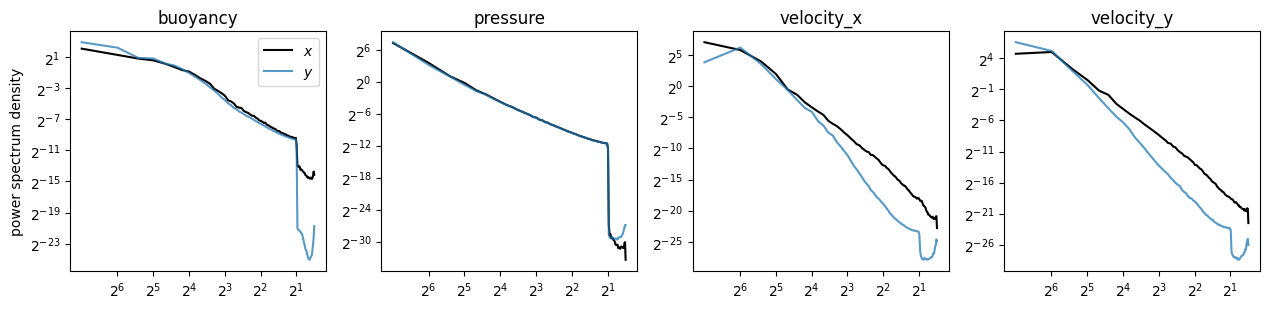

In [10]:
fig = plot_psd(x_gt[:, 16], x_hat[:, 16], fields=cfg.dataset.fields)